# Figure 5: Retained Flux

## 1. Imports

In [1]:
import json
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from applefy.detections.contrast import Contrast
from applefy.utils.file_handling import load_adi_data
from applefy.utils import flux_ratio2mag
from applefy.utils.photometry import AperturePhotometryMode

from fours.detection_limits.applefy_wrapper import PCADataReductionGPU
from fours.utils.data_handling import read_fours_root_dir
from fours.utils.setups import contrast_grid_setup_1

## 2. Load the dataset

In [2]:
dataset_name = "HD22049_303_199_C-0065_C_"
root_dir = Path(read_fours_root_dir())
json_file = root_dir / Path("30_data/" + dataset_name + ".json")

Data in the FOURS_ROOT_DIR found. Location: /fast/mbonse/s4


In [3]:
experiment_root_dir = root_dir / Path("70_results/x1_fake_planet_experiments/" + dataset_name)
experiment_root_dir.mkdir(exist_ok=True)

In [4]:
with open(json_file) as f:
    parameter_config = json.load(f)

dit_psf_template = float(parameter_config["dit_psf"])
dit_science = float(parameter_config["dit_science"])
fwhm = float(parameter_config["fwhm"])
scaling_factor = float(parameter_config["nd_scaling"])
lambda_reg = float(parameter_config["lambda_reg"])
svd_approx = int(parameter_config["svd_approx"])
pixel_scale=0.02718

In [5]:
dataset_file = root_dir / Path("30_data/" + dataset_name + ".hdf5")

In [6]:
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag="object_stacked_05",
    psf_template_tag="psf_template",
    para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

In [7]:
# we want the image to show the innermost 1.2 arcsec
print(1.2 / pixel_scale * 2)

88.30022075055187


In [8]:
# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

## 3. Create Contrast Instance

In [9]:
contrast_instance = Contrast(
    science_sequence=science_data,
    psf_template=psf_template,
    parang_rad=angles,
    psf_fwhm_radius=fwhm / 2,
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    scaling_factor=scaling_factor,
    checkpoint_dir=experiment_root_dir)

In [10]:
# get fake planet setup
flux_ratios, separations, num_fake_planets = contrast_grid_setup_1(fwhm)

In [11]:
contrast_instance.design_fake_planet_experiments(
    flux_ratios=flux_ratios,
    num_planets=num_fake_planets,
    separations=separations,
    overwrite=True)

Overwriting existing config files.


## 4. Restore PCA results

In [12]:
pca_algorithm_function = PCADataReductionGPU(
        approx_svd=8000,
        pca_numbers=[10, 50, 60, 70, 80, 90, 100],
        device="cpu",
        work_dir=None,
        special_name="stacked_05",
        verbose=False)

In [13]:
contrast_instance.run_fake_planet_experiments(
    algorithm_function=pca_algorithm_function,
    num_parallel=1)

Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:55<00:00, 17.07it/s]

[DONE]


## 5. Compute the throughput

In [14]:
# Use pixel values spaced by the FWHM
photometry_mode_planet = AperturePhotometryMode("F")
photometry_mode_noise = AperturePhotometryMode("P")

In [15]:
contrast_instance.prepare_contrast_results(
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise)

In [16]:
contrast_results_1 = contrast_instance.contrast_results["stacked_05_PCA_080_components"]
throughput_results_1 = contrast_results_1.compute_throughput().T

## 6. Create the Plot

In [17]:
throughput_results_1.index = np.round(flux_ratio2mag(throughput_results_1.index), 2)
throughput_results_1.columns = np.round((throughput_results_1.columns/3.6), 2)
throughput_results = throughput_results_1.iloc[:19, :].iloc[::2, ::2]

In [18]:
from matplotlib.colors import LogNorm

In [20]:
def plot_throughput(axis_in,
                    tmp_throughput_results,
                    color_bar):

    c_bar_kargs = dict(orientation = "vertical",
                       label = r"Retained flux")

    heat = sns.heatmap(tmp_throughput_results,
                       vmax=0.0, vmin=0.4,
                       annot=True,
                       cmap="YlGnBu",
                       ax=axis_in,
                       norm=LogNorm(),
                       cbar_ax=colorbar_ax,
                       annot_kws={"fontsize":11},
                       cbar_kws=c_bar_kargs)

    ylabels = ['{:d}'.format(int(float(x.get_text()))) for x in heat.get_yticklabels()]
    _=heat.set_yticklabels(ylabels)

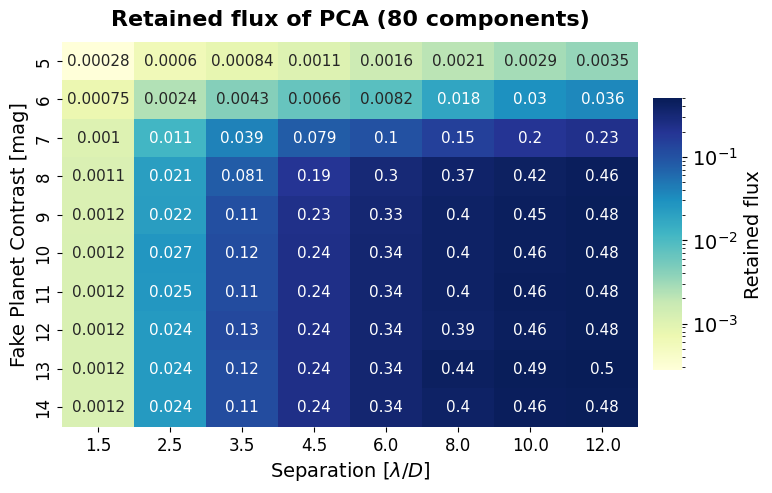

In [22]:
# 1. Create the plot layout ---------------------------------------
fig = plt.figure(constrained_layout=False, figsize=(8, 5))

gs0 = fig.add_gridspec(1, 2, width_ratios = [1, 0.05])
gs0.update(wspace=0.05)

gs1 = gridspec.GridSpecFromSubplotSpec(
    1, 1, subplot_spec = gs0[0],
    hspace=0.12)
gs2 = gridspec.GridSpecFromSubplotSpec(
    3, 1, subplot_spec = gs0[1],
    height_ratios=[0.1, 0.8, 0.1])

throughput_ax1 = fig.add_subplot(gs1[0])
colorbar_ax = fig.add_subplot(gs2[1])

# 2. Plot the throughput table ------------------------------------
plot_throughput(throughput_ax1, throughput_results,
                color_bar=False)
throughput_ax1.tick_params(
    axis='both', which='major', labelsize=12)

# 3. Create the colorbar ------------------------------------------
cbar = throughput_ax1.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
throughput_ax1.figure.axes[-1].yaxis.label.set_size(14)

# 4. Labels -------------------------------------------------------
throughput_ax1.set_ylabel(
    r"Fake Planet Contrast [mag]", size=14)
throughput_ax1.set_xlabel(
    r"Separation [$\lambda /D$]", size=14)

throughput_ax1.set_title("Retained flux of PCA (80 components)", y=1.02, size=16, fontweight="bold")

fig.patch.set_facecolor('white')
plt.savefig("./final_plots/04_Throughput.pdf", bbox_inches='tight')